In [1]:
%matplotlib inline
from hciplot import plot_frames, plot_cubes
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
import numpy as np
from packaging import version

In [2]:
import vip_hci as vip
vvip = vip.__version__
print("VIP version: ", vvip)
if version.parse(vvip) < version.parse("1.0.0"):
    msg = "Please upgrade your version of VIP"
    msg+= "It should be 1.0.0 or above to run this notebook."
    raise ValueError(msg)
elif version.parse(vvip) <= version.parse("1.0.3"):
    from vip_hci.conf import time_ini, timing
    from vip_hci.medsub import median_sub
    from vip_hci.metrics import cube_inject_fakedisk, ScatteredLightDisk
else:
    from vip_hci.config import time_ini, timing
    from vip_hci.fm import cube_inject_fakedisk, ScatteredLightDisk
    from vip_hci.psfsub import median_sub
# common to all versions:
from vip_hci.var import create_synth_psf

VIP version:  1.3.2


## Example of Disk

In [3]:
pixel_scale=0.01225 # pixel scale in arcsec/px
dstar= 320 # distance to the star in pc
nx = 50 # number of pixels of your image in X
ny = 50 # number of pixels of your image in Y

In [4]:
itilt = 45. # inclination of your disk in degrees
a = 70. # semimajoraxis of the disk in au
ksi0 = 3. # reference scale height at the semi-major axis of the disk
gamma = 2. # exponant of the vertical exponential decay
alpha_in = 12
alpha_out = -12
beta = 1

Double Henyey-Greenstein phase function scattering:

In [5]:
g1=0.7
g2=-0.2
weight1=0.665

# 1985 solar system paper, zodiacal dust, Hong

In [6]:
fake_disk1 = ScatteredLightDisk(nx=nx, ny=ny, distance=dstar,
                                itilt=itilt, omega=0, pxInArcsec=pixel_scale, pa=0,
                                density_dico={'name':'2PowerLaws','ain':alpha_in,'aout':alpha_out,
                                              'a':a,'e':0.0,'ksi0':ksi0,'gamma':gamma,'beta':beta},
                                spf_dico={'name':'DoubleHG', 'g':[g1,g2], 'weight':weight1, 'polar':False},
                                flux_max=1.)

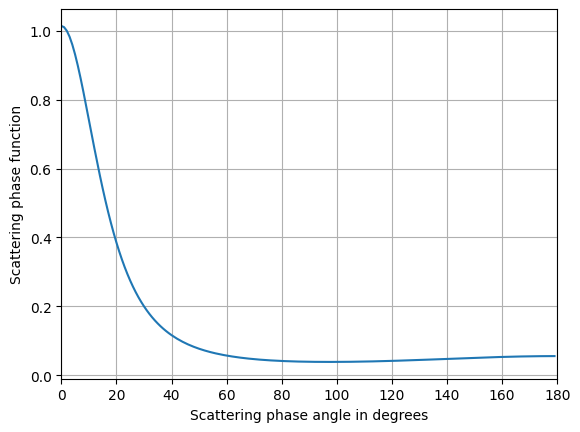

In [7]:
fake_disk1.phase_function.plot_phase_function()

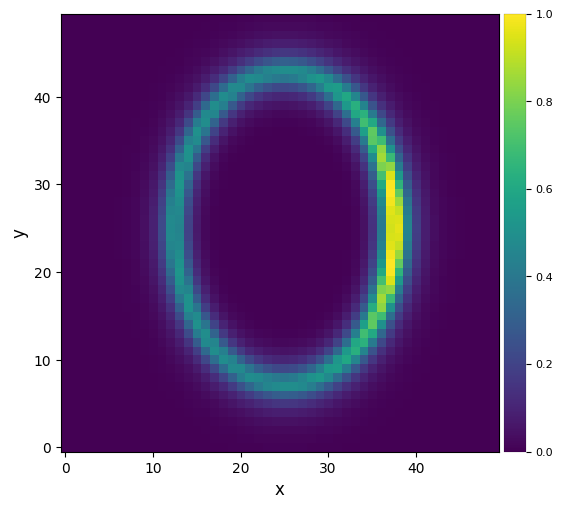

In [8]:
fake_disk1_map = fake_disk1.compute_scattered_light()
plot_frames(fake_disk1_map, grid=False, size_factor=6)

In [9]:
fake_disk1.print_info()

-----------------------------------
Geometrical properties of the image
-----------------------------------
Image size: 50 px by 50 px
Pixel size: 0.0123 arcsec/px or 3.92 au/px
Distance of the star 320.0 pc
From -98.0 au to 94.1 au in X
From -98.0 au to 94.1 au in Y
Position angle of the disc: 0.00 degrees
Inclination 45.00 degrees
Argument of pericenter 0.00 degrees
Maximum flux of the disk 1.00
----------------------------
Dust distribution parameters
----------------------------
Reference semi-major axis: 70.0au
Semi-major axis at maximum dust density in plane z=0: 70.0au (same as ref sma if ain=-aout)
Semi-major axis at half max dust density: 64.2au / 76.3au for the inner/outer edge, or a FWHM of 12.1au
Semi-major axis at maximum dust surface density: 70.2au (same as ref sma if ain=-aout)
Ellipse p parameter: 70.0au
Ellipticity: 0.000
Inner slope: 12.00
Outer slope: -12.00
Density at the reference semi-major axis: 1.000e+00 (arbitrary unit
Scale height: 3.00 au at 70.00
Vertical p

## PSF

In [10]:
from astropy.io import fits

filename = "../Sphere_hr4796_PSF_convolution.fits"
fits.info(filename)

Filename: ../Sphere_hr4796_PSF_convolution.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (31, 31)   float32   


In [11]:
with fits.open(filename) as hdulist: 
    header = hdulist[0].header
    PSF = hdulist[0].data

In [12]:
print(repr(header))

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   31                                                  
NAXIS2  =                   31                                                  
EXTEND  =                    T                                                  


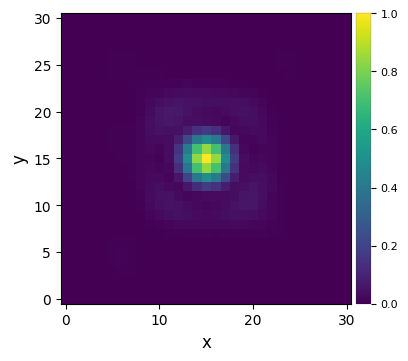

In [13]:
plot_frames(PSF, size_factor=4)

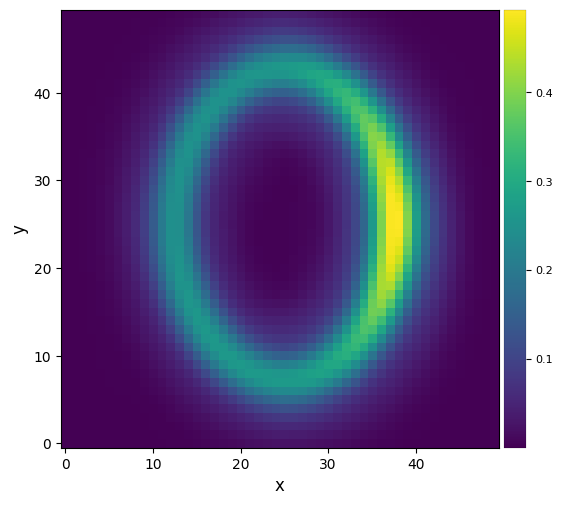

In [14]:
from astropy.convolution import convolve

fake_disk1_conv = convolve(fake_disk1_map,PSF)
plot_frames(fake_disk1_conv, grid=False, size_factor=6)

## Noise

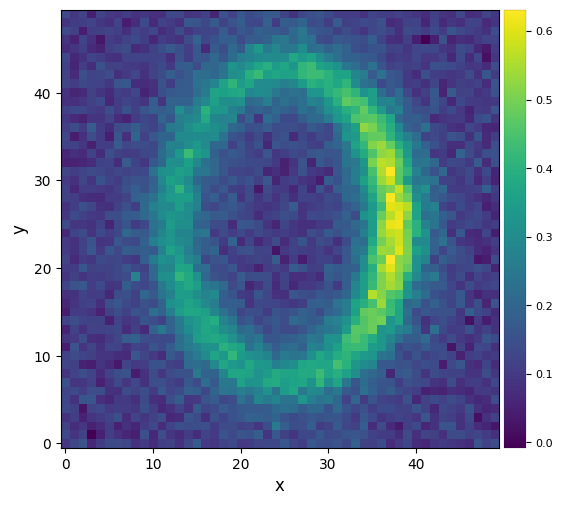

In [15]:
dim1 = fake_disk1_conv.shape[0]
dim2 = fake_disk1_conv.shape[1]

mean = 0 
var = 0.01
sigma = np.sqrt(var)
err = 0.1 + 0.3 * np.random.normal(loc=mean,scale=sigma,size=(dim1,dim2))
fake_disk1_conv_noise = fake_disk1_conv + err

plot_frames(fake_disk1_conv_noise, grid=False, size_factor=6)

## MCMC

In [20]:
def log_likelihood(theta, data, zerr):
    itilt, a, ksi0, alpha_in, alpha_out, g1, g2, weight1 = theta
    
    pixel_scale=0.01225 # pixel scale in arcsec/px
    dstar= 320 # distance to the star in pc
    nx = 50 # number of pixels of your image in X
    ny = 50 # number of pixels of your image in Y
    gamma = 2.
    beta = 1
    
    a = np.abs(a)
    ksi0 = np.abs(ksi0)
    weight1 = np.abs(weight1)
    if weight1 > 1:
        weight1 = 1

    fake_disk = ScatteredLightDisk(nx=nx, ny=ny, distance=dstar,
                                itilt=itilt, omega=0, pxInArcsec=pixel_scale, pa=0,
                                density_dico={'name':'2PowerLaws','ain':alpha_in,'aout':alpha_out,
                                              'a':a,'e':0.0,'ksi0':ksi0,'gamma':gamma,'beta':beta},
                                spf_dico={'name':'DoubleHG', 'g':[g1,g2], 'weight':weight1, 'polar':False},
                                flux_max=1.)
    model_map = fake_disk.compute_scattered_light()
    # convolve here too
    sigma2 = zerr**2
    
    return -0.5 * np.sum((data - model_map) ** 2 / sigma2 )

In [21]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([itilt, a, ksi0, alpha_in, alpha_out, g1, g2, weight1]) + 0.1 * np.random.randn(8)
soln = minimize(nll, initial, args=(fake_disk1_conv_noise, err))
itilt_ml, a_ml, ksi0_ml, alpha_in_ml, alpha_out_ml, g1_ml, g2_ml, weight1_ml = soln.x

print("Maximum likelihood estimates:")
print("Inclination = {0:.3f}".format(itilt_ml))
print("Semimajor axis = {0:.3f}".format(np.abs(a_ml)))
print("Reference scale height = {0:.3f}".format(np.abs(ksi0_ml)))
print("alpha_in = {0:.3f}".format(alpha_in_ml))
print("alpha_out = {0:.3f}".format(alpha_out_ml))
print("g1 = {0:.3f}".format(g1_ml))
print("g2 = {0:.3f}".format(g2_ml))
print("Weight = {0:.3f}".format(np.abs(weight1_ml)))

/home/localuser/Documents/LIU/VIP/vip_hci/fm/scattered_light_disk.py:354: RuntimeWarning: divide by zero encountered in double_scalars
  self.scattered_light_map *= (self.flux_max /
/home/localuser/Documents/LIU/VIP/vip_hci/fm/scattered_light_disk.py:354: RuntimeWarning: invalid value encountered in multiply
  self.scattered_light_map *= (self.flux_max /
/home/localuser/Documents/LIU/VIP/vip_hci/fm/scattered_light_disk.py:588: RuntimeWarning: invalid value encountered in power
  self.apeak_surface_density = self.a * np.power(-Gamma_in/Gamma_out,


Warning the inner slope is greater than 0.1
ain was changed from  -6.57 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from  24.78 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from  -6.57 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from  24.78 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from  -6.57 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from  24.78 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from  -6.57 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from  24.78 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from  -6.57 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from  24.78 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from  -6.57 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from  24.78 to -0.1
Warning the inner slope is greater

Warning the inner slope is greater than 0.1
ain was changed from -76339.94 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 150087.74 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -76339.94 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 150087.74 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -76339.94 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 150087.74 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -76339.94 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 150087.74 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -76339.94 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 150087.74 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -76339.94 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 150087.74 to -0.

Warning the inner slope is greater than 0.1
ain was changed from -312737816.35 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 614807971.29 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -312737816.35 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 614807971.29 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -312737821.01 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 614807971.29 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -312737816.35 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 614807980.45 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -312737816.35 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 614807971.29 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -312737816.35 to 0.1
Warning the outer slope is greater than -0.1

Warning the inner slope is greater than 0.1
ain was changed from -1280974164282.80 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 2518253498997.37 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -1280974145194.80 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 2518253536522.27 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -1280974145194.80 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 2518253498997.37 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -1280974145194.80 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 2518253498997.37 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -1280974145194.80 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 2518253498997.37 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -5123896580815.40 to 0.1


Warning the inner slope is greater than 0.1
ain was changed from -5246870098767320.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 10314766331941798.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -5246870098767320.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 10314766331941798.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -5246870098767320.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 10314766331941798.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -20987480395069316.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 41259065327767232.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -20987480395069316.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 41259065327767232.00 to -0.1
Warning the inner slope is greater than 0.1
ain was c

Warning the inner slope is greater than 0.1
ain was changed from -85964719698203967488.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 168997131582534615040.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -85964719698203967488.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 168997131582534615040.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -85964719698203967488.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 168997131582534615040.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -85964719698203967488.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 168997131582534615040.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -85964720979178110976.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 168997131582534615040.00 to -0.1
Warning the inn

Warning the inner slope is greater than 0.1
ain was changed from -88027872970960862707712.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 173053062740515445800960.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -88027872970960862707712.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 173053062740515445800960.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -88027872970960862707712.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 173053062740515445800960.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -88027872970960862707712.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 173053062740515445800960.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -88027874282678385639424.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 173053062740515445800

Warning the inner slope is greater than 0.1
ain was changed from -90140541922263923412697088.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 177206336246287816500183040.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -90140541922263923412697088.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 177206336246287816500183040.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -90140541922263923412697088.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 177206336246287816500183040.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -90140541922263923412697088.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 177206336246287816500183040.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -90140543265462666894770176.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed

Warning the inner slope is greater than 0.1
ain was changed from -92303914928398257574601818112.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 181459288316198724096187432960.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -92303914928398257574601818112.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 181459288316198724096187432960.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -92303914928398257574601818112.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 181459288316198724096187432960.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -92303914928398257574601818112.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 181459288316198724096187432960.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -92303916303833770900244660224.00 to 0.1
Warning the outer slope is greater

Warning the inner slope is greater than 0.1
ain was changed from -94519208886679815756392261746688.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 185814311235787493474495931351040.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -94519208886679815756392261746688.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 185814311235787493474495931351040.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -94519208886679815756392261746688.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 185814311235787493474495931351040.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -94519208886679815756392261746688.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 185814311235787493474495931351040.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -94519210295125781401850532069376.00 to 0.1
Warning

Warning the inner slope is greater than 0.1
ain was changed from -96787669899960131334545676028608512.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 190273854705446393317883833703464960.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -96787669899960131334545676028608512.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 190273854705446393317883833703464960.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -96787669899960131334545676028608512.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 190273854705446393317883833703464960.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -96787669899960131334545676028608512.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 190273854705446393317883833703464960.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -96787671342208800155494944

Warning the inner slope is greater than 0.1
ain was changed from -99110573977559174486574772253295116288.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 194840427218377106757513045712348119040.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -99110573977559174486574772253295116288.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 194840427218377106757513045712348119040.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -99110573977559174486574772253295116288.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 194840427218377106757513045712348119040.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -99110573977559174486574772253295116288.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 194840427218377106757513045712348119040.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -99

Warning the inner slope is greater than 0.1
ain was changed from -101489227753020594674252566787374199078912.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 199516597471618157319693358809444473896960.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -101489227753020594674252566787374199078912.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 199516597471618157319693358809444473896960.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -101489227753020594674252566787374199078912.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 199516597471618157319693358809444473896960.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -101489227753020594674252566787374199078912.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 199516597471618157319693358809444473896960.00 to -0.1
Warning the inner slope is greater than 

Warning the inner slope is greater than 0.1
ain was changed from -103924969219093088946434628390271179856805888.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 204304995810936993095365999420871141270487040.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -103924969219093088946434628390271179856805888.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 204304995810936993095365999420871141270487040.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -103924969219093088946434628390271179856805888.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 204304995810936993095365999420871141270487040.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -103924969219093088946434628390271179856805888.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 204304995810936993095365999420871141270487040.00 to -0.1
Warning the inne

Warning the inner slope is greater than 0.1
ain was changed from -106419168480351323081149059471637688173369229312.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 209208315710399480929654783406972048660978728960.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -106419168480351323081149059471637688173369229312.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 209208315710399480929654783406972048660978728960.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -106419168480351323081149059471637688173369229312.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 209208315710399480929654783406972048660978728960.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -106419168480351323081149059471637688173369229312.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 209208315710399480929654783406972048660978728960.00 

Warning the inner slope is greater than 0.1
ain was changed from -108973228523879754835096636898956992689530090815488.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 214229315287449068471966498208739377828842218455040.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -108973228523879754835096636898956992689530090815488.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 214229315287449068471966498208739377828842218455040.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -108973228523879754835096636898956992689530090815488.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 214229315287449068471966498208739377828842218455040.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -108973228523879754835096636898956992689530090815488.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 2142293152874490684719664982087

Warning the inner slope is greater than 0.1
ain was changed from -27897146502113217237784739046132990128519703248764928.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 54842704713586961528823423541437280724183607924490240.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -27897146502113217237784739046132990128519703248764928.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 54842704713586961528823423541437280724183607924490240.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -111588586008452868951138956184531960514078812995059712.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 219370818854347846115293694165749122896734431697960960.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -111588586008452868951138956184531960514078812995059712.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 21937081885434

Warning the inner slope is greater than 0.1
ain was changed from -28566678018163934451491572783240181891604176126735286272.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 56158930463546312595157042146331776389231341076874264576.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -28566678018163934451491572783240181891604176126735286272.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 56158929626713048605515185706431775461564014514678005760.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -28566678018163934451491572783240181891604176126735286272.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 56158929626713048605515185706431775461564014514678005760.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -28566678018163934451491572783240181891604176126735286272.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed f

Warning the inner slope is greater than 0.1
ain was changed from -29252278290599868878327370530037946257002676353776933142528.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 57506743937754161772047550163386138072641550863030277898240.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -29252278726492782388945862578189016070000200424972202541056.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 57506743937754161772047550163386138072641550863030277898240.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -29252278290599868878327370530037946257002676353776933142528.00 to 0.1
Warning the outer slope is greater than -0.1
aout was changed from 57506744794671424097440811157843739022572893262719246925824.00 to -0.1
Warning the inner slope is greater than 0.1
ain was changed from -29252278290599868878327370530037946257002676353776933142528.00 to 0.1
Warning the outer slope is greater than -0

In [22]:
def log_likelihood1(theta, data, zerr):
    itilt, a, ksi0, alpha_in, alpha_out, g1, g2, weight1 = theta
    
    pixel_scale=0.01225 # pixel scale in arcsec/px
    dstar= 320 # distance to the star in pc
    nx = 50 # number of pixels of your image in X
    ny = 50 # number of pixels of your image in Y
    gamma = 2.
    beta = 1

    fake_disk = ScatteredLightDisk(nx=nx, ny=ny, distance=dstar,
                                itilt=itilt, omega=0, pxInArcsec=pixel_scale, pa=0,
                                density_dico={'name':'2PowerLaws','ain':alpha_in,'aout':alpha_out,
                                              'a':a,'e':0.0,'ksi0':ksi0,'gamma':gamma,'beta':beta},
                                spf_dico={'name':'DoubleHG', 'g':[g1,g2], 'weight':weight1, 'polar':False},
                                flux_max=1.)
    model_map = fake_disk.compute_scattered_light()
    # convolve here too
    sigma2 = zerr**2
    
    return -0.5 * np.sum((data - model_map) ** 2 / sigma2 )

In [23]:
%%time

def log_prior(theta):
    itilt, a, ksi0, alpha_in, alpha_out, g1, g2, weight1 = theta
    if 0 < itilt < 90.0 and 0.0 < a < 100.0 and 0.0 < ksi0 < 100.0 and -20.0 < alpha_in < 20.0 and -20.0 < alpha_out < 20.0 and 0.0 < g1 < 1.0 and -1.0 < g2 < 0.0 and 0.0 < weight1 < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, data, zerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood1(theta, data, zerr)

import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 8)
pos[:,2] = np.abs(pos[:,2])
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(fake_disk1_conv_noise, err)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|███████████████████████████████████████| 5000/5000 [42:33<00:00,  1.96it/s]

CPU times: user 42min 34s, sys: 971 ms, total: 42min 35s
Wall time: 42min 33s


State([[ 4.38379708e+01  7.12177791e+01  2.62616164e-01  5.62492327e+00
  -7.48290176e+00  9.84495925e-01 -2.59879965e-01  9.83786584e-01]
 [ 4.38868361e+01  7.13848301e+01  3.14063423e-01  5.51596134e+00
  -7.80772561e+00  9.51816741e-01 -2.53112441e-01  9.48150938e-01]
 [ 4.38349942e+01  7.15287131e+01  3.49177409e-01  5.56750956e+00
  -7.93138855e+00  9.30686006e-01 -2.44892289e-01  9.24738052e-01]
 [ 4.32167954e+01  7.04534802e+01  9.67035478e-02  5.86471411e+00
  -7.54706336e+00  9.24582267e-01 -2.73402730e-01  9.21486656e-01]
 [ 4.31784351e+01  7.04653215e+01  3.67054425e-01  5.72293855e+00
  -7.61212589e+00  9.76281268e-01 -2.65268123e-01  9.75210950e-01]
 [ 4.35562248e+01  7.08189400e+01  3.45083121e-01  5.75512833e+00
  -7.60207895e+00  9.79895223e-01 -2.54287870e-01  9.77907732e-01]
 [ 4.33141738e+01  7.06888716e+01  5.23985427e-01  5.76033443e+00
  -7.98074383e+00  9.77268259e-01 -2.44039106e-01  9.74434249e-01]
 [ 4.31914372e+01  7.04781196e+01  6.75377537e-01  5.54901648e+

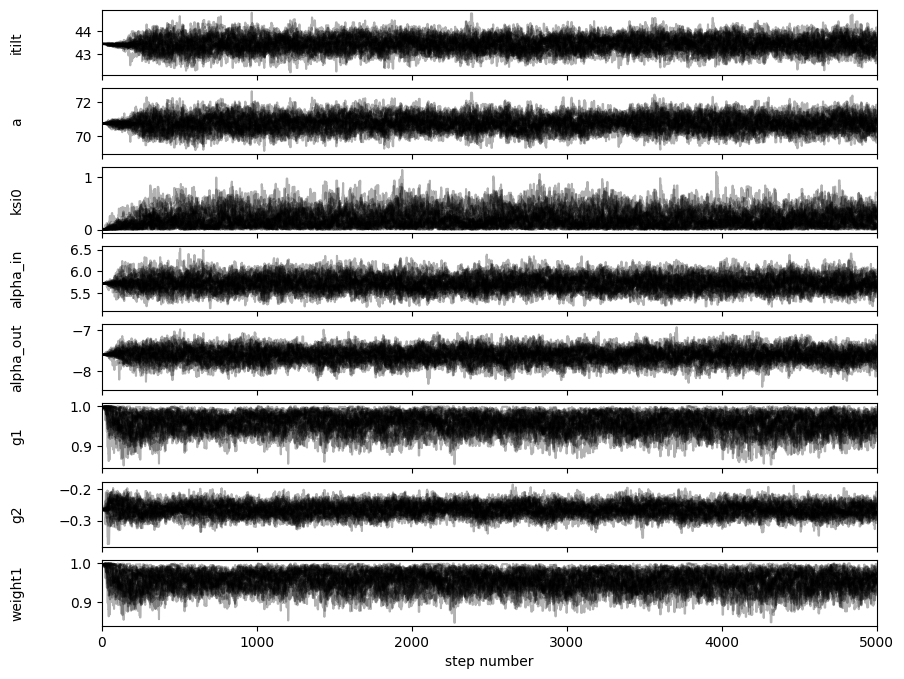

In [24]:
fig, axes = plt.subplots(8, figsize=(10, 8), sharex=True)
samples = sampler.get_chain()
labels = ["itilt", "a", "ksi0", "alpha_in", "alpha_out", "g1", "g2", "weight1"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [25]:
flat_samples = sampler.get_chain(discard=00, thin=15, flat=True)
print(flat_samples.shape)

(10656, 8)


In [26]:
from IPython.display import display, Math

labels = ["itilt", "a", "ksi0", "alpha_{in}", "alpha_{out}", "g_1", "g_2", "weight1"]

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

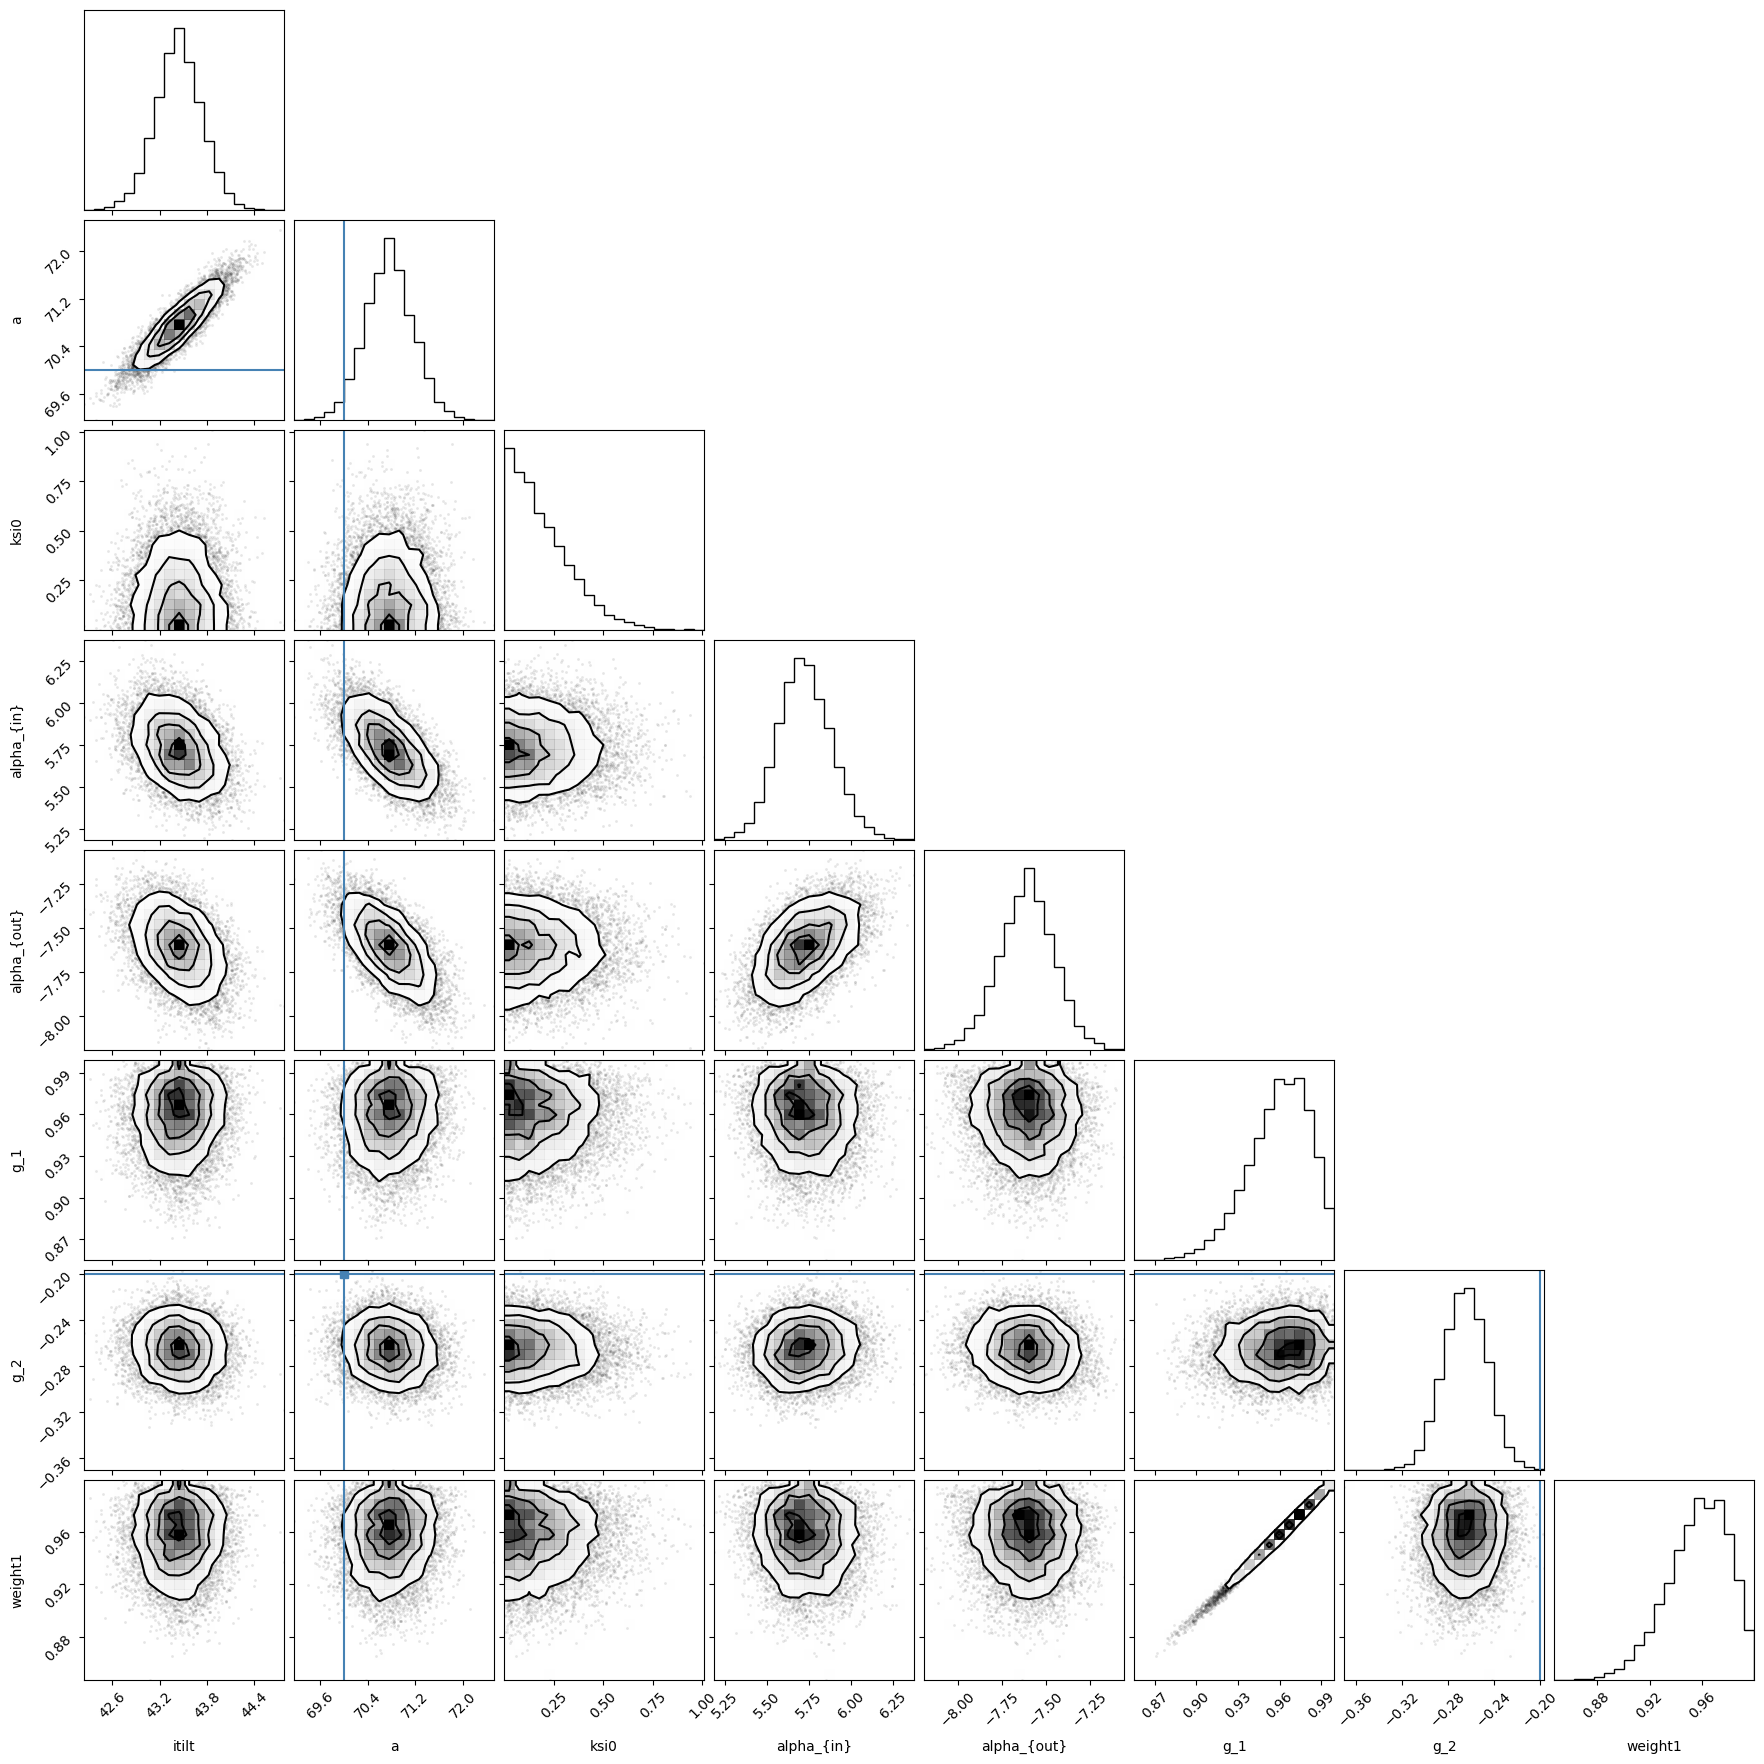

In [27]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[itilt,a,ksi0,alpha_in,alpha_out,g1,g2,weight1]
);